Files already downloaded and verified
Files already downloaded and verified
Data loaded successfully...
[epoch 1, iter   200] loss: 1.958
[epoch 1, iter   400] loss: 1.676
[epoch 1, iter   600] loss: 1.563
epoch 1: train_acc 47.802, test_acc 47.880
[epoch 2, iter   200] loss: 1.432
[epoch 2, iter   400] loss: 1.378
[epoch 2, iter   600] loss: 1.367
epoch 2: train_acc 53.498, test_acc 52.600
[epoch 3, iter   200] loss: 1.286
[epoch 3, iter   400] loss: 1.275
[epoch 3, iter   600] loss: 1.247
epoch 3: train_acc 56.772, test_acc 55.200
[epoch 4, iter   200] loss: 1.186
[epoch 4, iter   400] loss: 1.191
[epoch 4, iter   600] loss: 1.180
epoch 4: train_acc 60.680, test_acc 58.650
[epoch 5, iter   200] loss: 1.115
[epoch 5, iter   400] loss: 1.123
[epoch 5, iter   600] loss: 1.094
epoch 5: train_acc 62.494, test_acc 58.910
[epoch 6, iter   200] loss: 1.052
[epoch 6, iter   400] loss: 1.067
[epoch 6, iter   600] loss: 1.054
epoch 6: train_acc 63.828, test_acc 60.120
[epoch 7, iter   200] loss

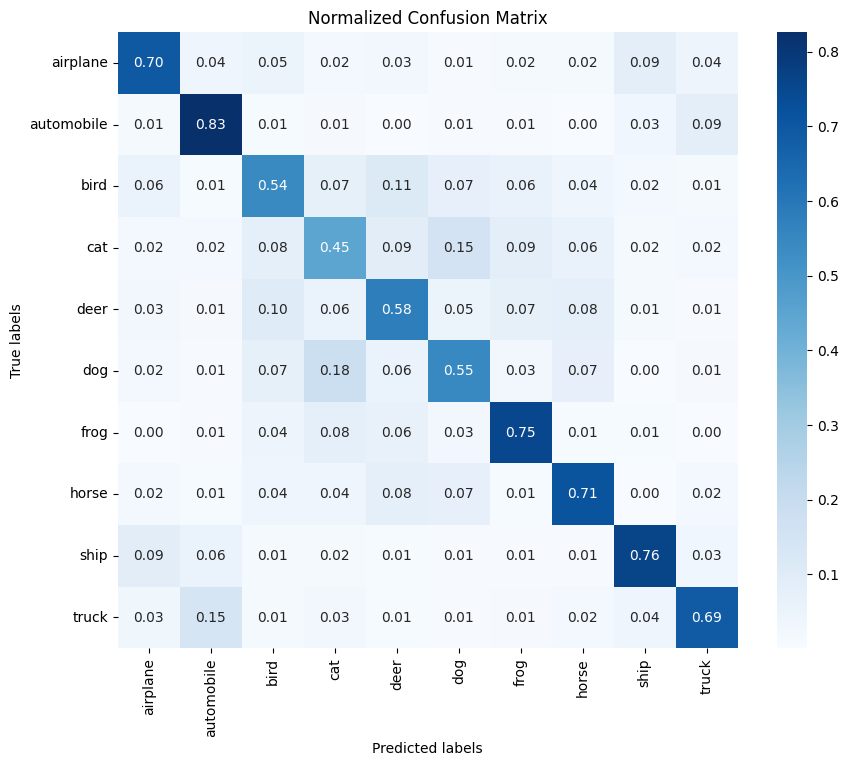

In [10]:
# CIFAR-10 Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision as tv
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import math
import os

from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix
import seaborn as sns


train_batch_size = 64
test_batch_size = 1000

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # Adjust input channels to 3 for CIFAR-10
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # Adjust output to 10 for CIFAR-10

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

def load_data():
    transform = transforms.Compose([
        transforms.Resize((32, 32)),  # Resize images to 32x32 for CIFAR-10
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjust normalization for CIFAR-10
    ])
    train_set = tv.datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )
    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=train_batch_size,
        shuffle=True,
        num_workers=2
    )
    test_set = tv.datasets.CIFAR10(
        root='./data',
        train=False,
        download=True,
        transform=transform
    )
    test_loader = torch.utils.data.DataLoader(
        test_set,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=2
    )
    print("Data loaded successfully...")
    return train_loader, test_loader

def accuracy(model, data_loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for data in data_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return (100 * correct / total)

def train(train_loader, test_loader, model, criterion, optimizer, scheduler, max_epoch):
    train_acc = []
    test_acc = []
    for epoch in range(max_epoch):
        model.train()
        running_loss = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 200 == 199:
                print("[epoch %d, iter %5d] loss: %.3f" % (epoch+1, i+1, running_loss / 200))
                running_loss = 0.0


        # Update learning rate
        scheduler.step()

        train_acc_epoch = accuracy(model, train_loader)
        test_acc_epoch = accuracy(model, test_loader)
        train_acc.append(train_acc_epoch)
        test_acc.append(test_acc_epoch)
        print("epoch %d: train_acc %.3f, test_acc %.3f" % (epoch+1, train_acc_epoch, test_acc_epoch))

    return train_acc, test_acc

def display(train_acc, test_acc):
    fig, ax = plt.subplots()
    ax.plot(range(1, len(train_acc) + 1), train_acc, color='r', label='train_acc')
    ax.plot(range(1, len(test_acc) + 1), test_acc, color='b', label='test_acc')
    ax.legend(loc='lower right')
    plt.show()

def test(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalize
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Normalized Confusion Matrix')
    plt.show()


if __name__ == '__main__':
    # Input CIFAR-10
    train_loader, test_loader = load_data()
    # New model
    net = Net()

    # Training
    learning_rate = 0.0008
    max_epoch = 30
    criterion = nn.CrossEntropyLoss()
    #optimizer = optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))  # You can adjust the betas parameter for momentum

  #Learning rate scheduler
    step_size = 15  # Step size for learning rate decay
    gamma = 0.1     # Multiplicative factor for learning rate decay
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

    train_acc, test_acc = train(train_loader, test_loader, net, criterion, optimizer, scheduler, max_epoch)

    # display(train_acc, test_acc)
    # Get predictions and labels
    all_preds, all_labels = test(net, test_loader)

    # Plot confusion matrix
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    plot_confusion_matrix(all_labels, all_preds, classes)